In [ ]:
from google.colab import drive
drive.mount("/content/drive")

: 

In [ ]:
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.applications import MobileNetV2
from keras import layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam
import pandas as pd
import numpy as np
import os
import random
import cv2

In [ ]:
dir_path = "/content/drive/MyDrive/Birds"
train_path = f"{dir_path}/train"
test_path = f"{dir_path}/test"
valid_path = f"{dir_path}/valid"
target_size = (224,224)
input_shape = (224,224,3)

In [ ]:
class_count=pd.Series(dtype="float64")

for dirpath,dirnames,filenames in os.walk(train_path):
    
    bird_class=dirpath.split(os.path.sep)[-1]
    number_image=len(filenames)
    
    class_count[bird_class] = number_image

# train index with zero value removed
class_count.drop(["train"],inplace=True)

# sorting series alphabetically in order to match folder structure
class_count.sort_index(inplace=True)

In [ ]:
total_sample = class_count.sum()
total_class = class_count.size
mean_sample_class = class_count.mean()
most_sample = class_count.nlargest()

most_sample_string=""
for index,item in most_sample.items():
  most_sample_string += f"{index} ({item}) "

print(f"""Total sample count : {total_sample}
Total class count : {total_class}
Mean sample per class : {mean_sample_class}
Classes that has most samples : {most_sample_string}""")

Total sample count : 75394
Total class count : 475
Mean sample per class : 158.7242105263158
Classes that has most samples : HOUSE FINCH (248) D-ARNAUDS BARBET (233) OVENBIRD (233) SWINHOES PHEASANT (217) WOOD DUCK (214) 


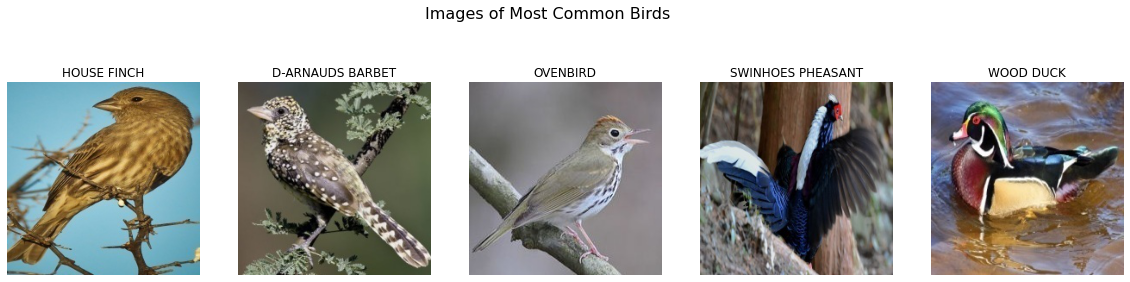

In [ ]:
plt.figure(figsize=(20,5))
plt.suptitle('Images of Most Common Birds', fontsize=16)

for index,bird_class in enumerate(most_sample.index):
  class_path = f"{train_path}/{bird_class}"
  img_name = random.choice(os.listdir(class_path))
  img = plt.imread(f"{class_path}/{img_name}")
  plt.subplot(1,5,index+1)
  plt.axis("off")
  plt.title(bird_class)
  plt.imshow(img)

In [ ]:
def show_class_images(bird_class):
  class_path = f"{train_path}/{bird_class}"
  class_images = os.listdir(class_path)
  
  img_names = random.sample(class_images,k=6)
  
  plt.figure(figsize=(12,8))
  plt.suptitle(f"Images of {bird_class}",fontsize=16)

  for index,image in enumerate(img_names):
    img = plt.imread(f"{class_path}/{image}")
    plt.subplot(2,3,index+1)
    plt.axis("off")
    plt.imshow(img)

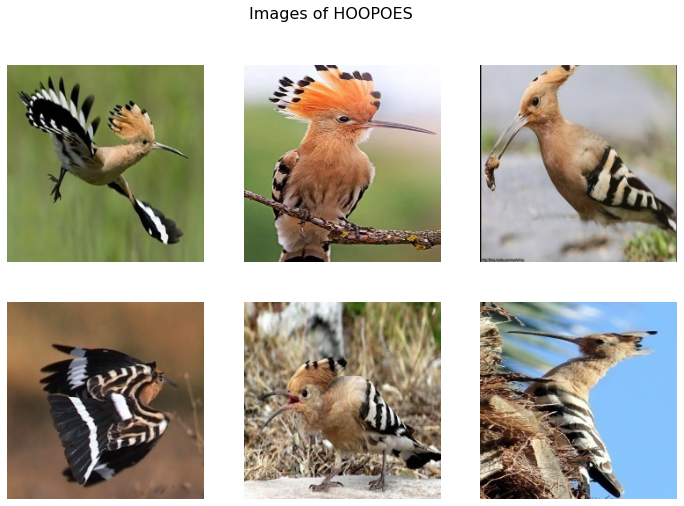

In [ ]:
show_class_images("HOOPOES")

In [ ]:
train_datagen = ImageDataGenerator(
    shear_range=0.1,
    zoom_range=0.1,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255
)

test_val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory = train_path,
    class_mode = "categorical",
    target_size = target_size,
    shuffle=True
)

val_generator = test_val_datagen.flow_from_directory(
    directory = valid_path,
    class_mode = "categorical",
    target_size = target_size,
    shuffle=True
)

test_generator = test_val_datagen.flow_from_directory(
    directory = test_path,
    class_mode = "categorical",
    target_size = target_size,
    shuffle=True
)

Found 75394 images belonging to 475 classes.
Found 2375 images belonging to 475 classes.
Found 2375 images belonging to 475 classes.


In [ ]:
mobilenet = MobileNetV2(weights = "imagenet",
                        input_shape = input_shape,
                        include_top = False)

mobilenet.trainable = False

inputs = layers.Input(shape=(224, 224, 3))
x = mobilenet(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(475)(x)
outputs = layers.Activation("softmax")(x)

model = Model(inputs,outputs)

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 475)               608475    
                                                                 
 activation (Activation)     (None, 475)               0         
                                                                

In [ ]:
model.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(learning_rate=0.001),
    metrics = ["accuracy"]
)

callbacks=[ModelCheckpoint(filepath="bird_classifier.h5",monitor="val_accuracy",mode="max",save_best_only=True,save_weights_only=False,verbose=1),
           EarlyStopping(monitor="val_accuracy",patience=10,verbose=1,mode="max")]

In [ ]:
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 30,
    steps_per_epoch = len(train_generator)//32,
    validation_steps = len(val_generator)//32,
    callbacks = callbacks,
    workers=12,
    use_multiprocessing=True
)

Epoch 1/30
73/73 [==============================] - ETA: 0s - loss: 5.9724 - accuracy: 0.0715
Epoch 1: val_accuracy improved from -inf to 0.15625, saving model to bird_classifier.h5
73/73 [==============================] - 222s 3s/step - loss: 5.9724 - accuracy: 0.0715 - val_loss: 4.4809 - val_accuracy: 0.1562
Epoch 2/30
73/73 [==============================] - ETA: 0s - loss: 3.8485 - accuracy: 0.2667
Epoch 2: val_accuracy improved from 0.15625 to 0.42188, saving model to bird_classifier.h5
73/73 [==============================] - 169s 2s/step - loss: 3.8485 - accuracy: 0.2667 - val_loss: 3.0448 - val_accuracy: 0.4219
Epoch 3/30
73/73 [==============================] - ETA: 0s - loss: 2.9031 - accuracy: 0.4075
Epoch 3: val_accuracy improved from 0.42188 to 0.50000, saving model to bird_classifier.h5
73/73 [==============================] - 164s 2s/step - loss: 2.9031 - accuracy: 0.4075 - val_loss: 2.4112 - val_accuracy: 0.5000
Epoch 4/30
73/73 [==============================] - ETA: 0

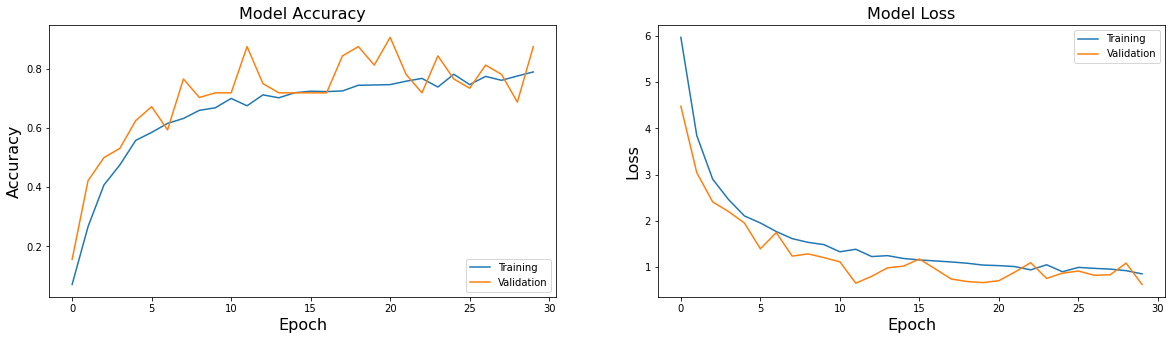

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"],label="Training")
plt.plot(history.history["val_accuracy"],label="Validation")
plt.legend(loc="lower right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.title("Model Accuracy", fontsize=16)

plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training")
plt.plot(history.history["val_loss"],label="Validation")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.title("Model Loss", fontsize=16)

plt.show()

In [ ]:
loss,accuracy = model.evaluate(test_generator)
print(f"""Test Loss : {loss:.2f}
Test Accuracy : {(accuracy*100):.2f}%""")

75/75 [==============================] - 1726s 23s/step - loss: 0.6371 - accuracy: 0.8371
Test Loss : 0.64
Test Accuracy : 83.71%


In [ ]:
def predict_sample(path):
  img=load_img(path,target_size=target_size)
  img=img_to_array(img,dtype=np.uint8)
  img=np.array(img) / 255.0
  p=model.predict(img.reshape(1,224,224,3))
  predicted_class=np.argmax(p[0])

  return img,p,predicted_class

class_labels = {index:bird_class for index,bird_class in enumerate(class_count.index)}

1/1 [==============================] - 0s 25ms/step


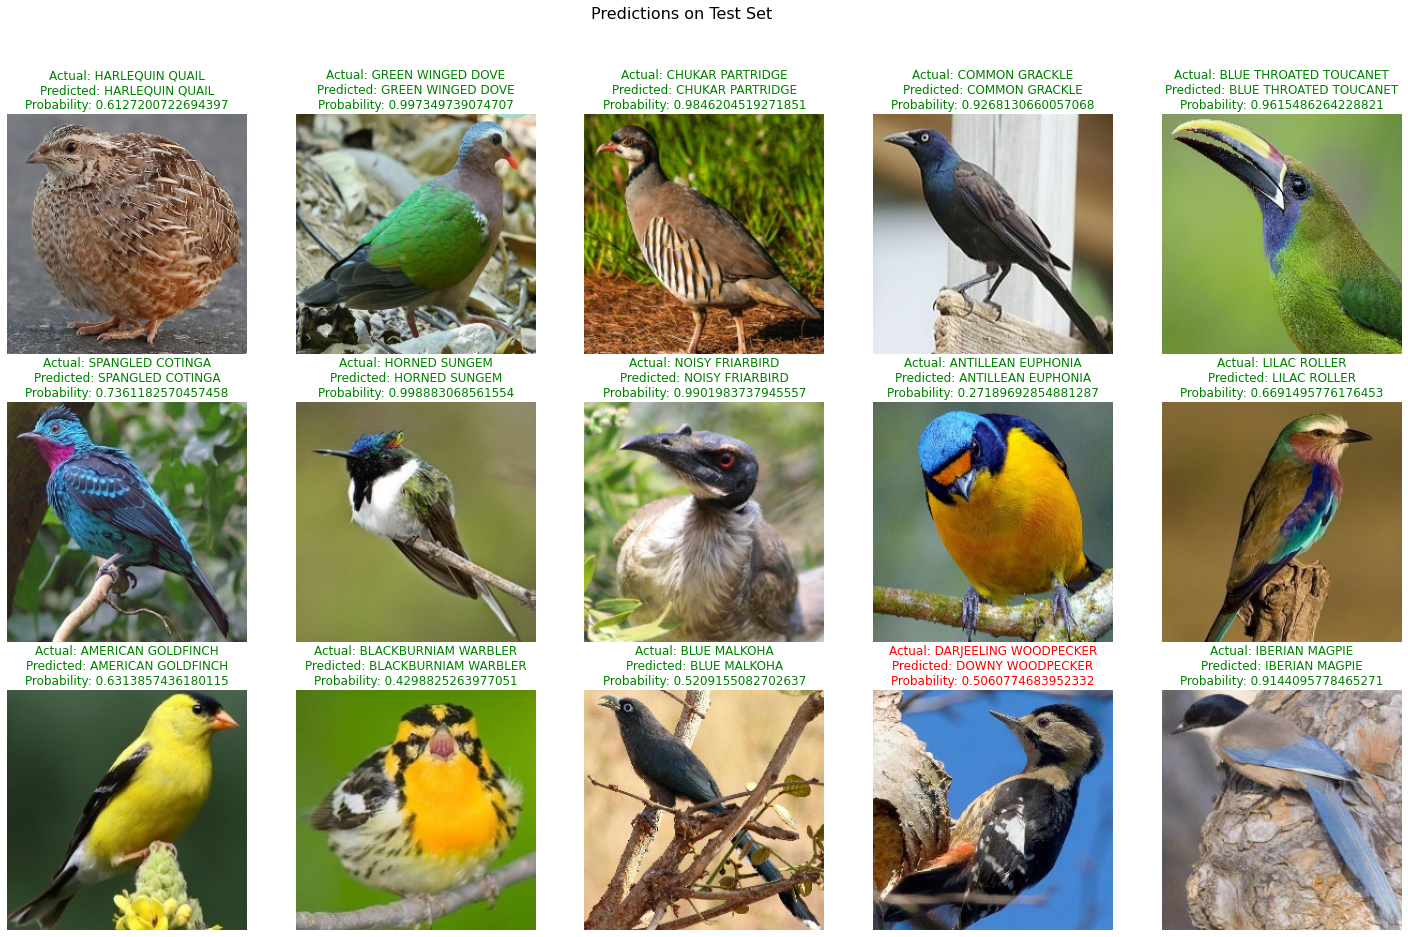

In [ ]:
plt.figure(figsize=(25,15))
plt.suptitle("Predictions on Test Set",fontsize=16)

for i in range(15):
  random_class = random.choice(list(class_labels.values()))
  class_path = f"{test_path}/{random_class}"

  random_img = random.choice(os.listdir(class_path))
  img_path = f"{class_path}/{random_img}"

  img,p,predicted_class = predict_sample(img_path)

  predicted = class_labels[predicted_class]
  maximum_probability = np.max(p[0],axis=-1)

  plt.subplot(3,5,i+1)
  plt.axis("off")
  if predicted == random_class :
    title_color = "g"
  else :
    title_color = "r"
  plt.title(f"Actual: {random_class}\nPredicted: {predicted}\nProbability: {maximum_probability}",c=title_color)
  plt.imshow(img)

In [ ]:
tflite_model = tf.keras.models.load_model('bird_classifier.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
tflite_save = converter.convert()
open("bird_classifier.tflite", "wb").write(tflite_save)

11298472